# Milestone project 2: Skimlit

## confirm access to GPU

In [ ]:
!nvidia-smi -L

/bin/bash: line 1: nvidia-smi: command not found


## Get data

In [ ]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [ ]:
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [ ]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os
filenames = [data_dir + filename for filename in os.listdir(data_dir)]
filenames

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data

In [ ]:
# Create function to read the lines of a document
def get_lines(filename):
  with open(filename, "r") as f:
    return f.readlines()

In [ ]:
# read in he training lines
train_lines = get_lines(data_dir + "train.txt")
train_lines[:20]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

## Data modeling
```
[{
    'line_number': 0,
    'target': 'BACKGROUND',
    'text': 'Emotional eating is associated with overeating and the development of obesity .\n',
    'total_lines': 11
}]
```

In [ ]:
def preprocess_text_with_line_numbers(filename):
  input_lines = get_lines(filename)
  abstract_lines = ""
  abstract_samples = []

  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines()

      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split("\t")
        line_data["target"] = target_text_split[0]
        line_data["text"] = target_text_split[1]
        line_data["line_number"] = abstract_line_number
        line_data["total_lines"] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    else:
      abstract_lines += line
  return abstract_samples

In [ ]:
# get data from file and preprocess
%%time
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")
print(len(train_samples), len(val_samples), len(test_samples))

180040 30212 30135
CPU times: user 392 ms, sys: 130 ms, total: 523 ms
Wall time: 549 ms


In [ ]:
# Check the first abstract of the training data
train_samples[:10]

[{'target': 'OBJECTIVE',
  'text': 'To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
  'line_number': 0,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
  'line_number': 1,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
  'line_number': 2,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
  'line_number': 3,
  'total_lines': 11},
 {'target': 'METHODS',
  'text': 'Secondary outcome measures included the Western Ontari

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)
train_df.head(14)

,target,text,line_number,total_lines
0,OBJECTIVE,To investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,A total of @ patients with primary knee OA wer...,1,11
2,METHODS,Outcome measures included pain reduction and i...,2,11
3,METHODS,Pain was assessed using the visual analog pain...,3,11
4,METHODS,Secondary outcome measures included the Wester...,4,11
5,METHODS,"Serum levels of interleukin @ ( IL-@ ) , IL-@ ...",5,11
6,RESULTS,There was a clinically relevant reduction in t...,6,11
7,RESULTS,The mean difference between treatment arms ( @...,7,11
8,RESULTS,"Further , there was a clinically relevant redu...",8,11
9,RESULTS,These differences remained significant at @ we...,9,11


In [ ]:
# Distribution of labels
train_df["target"].value_counts()

,count
target,
METHODS,59353
RESULTS,57953
CONCLUSIONS,27168
BACKGROUND,21727
OBJECTIVE,13839


<Axes: ylabel='Frequency'>

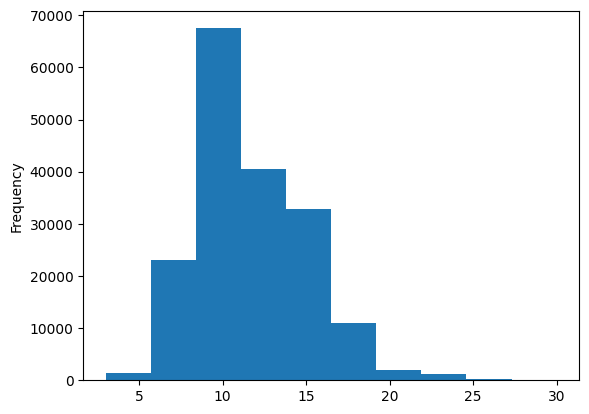

In [ ]:
# Length of different lines
train_df.total_lines.plot(kind="hist")

### Get lists of sentences

In [ ]:
# convert text lines into lists
train_sentences = train_df.text.to_list()
val_sentences = val_df.text.to_list()
test_sentences = test_df.text.to_list()
len(train_sentences), len(val_sentences), len(test_sentences)

(180040, 30212, 30135)

In [ ]:
# view first 0 lines
train_sentences[:10]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .',
 'Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .',
 'There was a clinic

## Make numeric labels

In [ ]:
# one hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder()
train_labels_one_hot = one_hot_encoder.fit_transform(train_df["target"].to_numpy().reshape(-1, 1)).toarray()
val_labels_one_hot = one_hot_encoder.transform(val_df["target"].to_numpy().reshape(-1, 1)).toarray()
test_labels_one_hot = one_hot_encoder.transform(test_df["target"].to_numpy().reshape(-1, 1)).toarray()
train_labels_one_hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

# label encode labels

In [ ]:
# extract labels and encode them into integers
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())
train_labels_encoded


array([3, 2, 2, ..., 4, 1, 1])

In [ ]:
# Get class names and number of classes from LabelEcoder instance
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## model 0: baseline

In [ ]:
from inspect import modulesbyfile
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()),
                    ("clf", MultinomialNB())
])

model_0.fit(X=train_sentences, y=train_labels_encoded)

# Create tokenization pipeline

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# evalate base line model
model_0.score(X=val_sentences, y=val_labels_encoded)

0.7218323844829869

In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([4, 1, 3, 2, 2, 2, 2, 2, 4, 4, 0, 4, 1, 1, 2, 2, 4, 1, 4, 4])

In [ ]:
### download helper function script
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2026-02-12 19:40:51--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2026-02-12 19:40:51 (62.6 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



In [ ]:
from helper_functions import calculate_results

In [ ]:
# calculate baseline results
baseline_results = calculate_results(y_true=val_labels_encoded,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

In [ ]:
train_sentences[:10]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .',
 'Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .',
 'There was a clinic

## Preparind data for deep sequence models

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
sent_lens = [len(sentence.split()) for sentence in train_sentences]
avg_sent_len = np.mean(sent_lens)
avg_sent_len

np.float64(26.338269273494777)

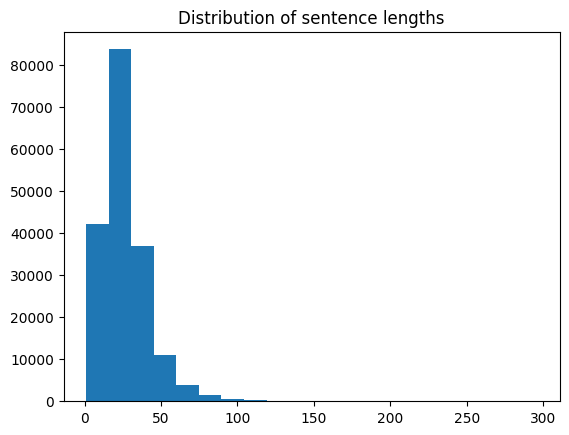

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=20)
plt.title("Distribution of sentence lengths")
plt.show()


In [ ]:
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

55

In [ ]:
max(sent_lens)

296

### Create text vectorizer layer

In [ ]:
max_tokens = 68000

In [ ]:
from tensorflow.keras.layers import TextVectorization
text_vectorizer = TextVectorization(max_tokens=max_tokens,
                                    output_sequence_length=output_seq_len)

In [ ]:
text_vectorizer.adapt(train_sentences)

In [ ]:
import random
target_sentence = random.choice(train_sentences)
print(f"Text:\n{target_sentence}")
print(f"\nLength of text: {len(target_sentence)}")
print(f"\nVectorized text:\n{text_vectorizer([target_sentence])}")

Text:
The long-term mortality rates did not differ in patients with severe sepsis assigned to HES @/@ @ versus Ringer 's acetate , but we could not reject a @ % relative increased or a @ % relative decreased mortality at @ year with HES at the @ % confidence level .

Length of text: 260

Vectorized text:
[[    2   335   259   162   112    31   544     5    12     7   289  1762
    123     6  3568   110  5480   130  2481    72    43   281    31 24840
      8   383    96    16     8   383   212   259    15   157     7  3568
     15     2   235   204     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [ ]:
rct_20k_text_vocab = text_vectorizer.get_vocabulary()
print(f"Number of words in vocab: {len(rct_20k_text_vocab)}")
print(f"Top 5 words: {rct_20k_text_vocab[:5]}")
print(f"Bottom 5 words: {rct_20k_text_vocab[-5:]}")

Number of words in vocab: 64841
Top 5 words: ['', '[UNK]', np.str_('the'), np.str_('and'), np.str_('of')]
Bottom 5 words: [np.str_('aainduced'), np.str_('aaigroup'), np.str_('aachener'), np.str_('aachen'), np.str_('aaacp')]


In [ ]:
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': False,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Create custom text embedding

In [ ]:
token_embed = layers.Embedding(input_dim=len(rct_20k_text_vocab),
                               output_dim=128,
                               mask_zero=True,
                               name="token_embedding")

In [ ]:
# show example embedding
print(f"Text:\n{target_sentence}")
vectorized_sentence = text_vectorizer([target_sentence])
print(f"\nVectorized text:\n{vectorized_sentence}")
embeded_sentence = token_embed(vectorized_sentence)
print(f"embeded text:\n{embeded_sentence}")
print(f"embeded text shape:\n{embeded_sentence.shape}")

Text:
The long-term mortality rates did not differ in patients with severe sepsis assigned to HES @/@ @ versus Ringer 's acetate , but we could not reject a @ % relative increased or a @ % relative decreased mortality at @ year with HES at the @ % confidence level .

Vectorized text:
[[    2   335   259   162   112    31   544     5    12     7   289  1762
    123     6  3568   110  5480   130  2481    72    43   281    31 24840
      8   383    96    16     8   383   212   259    15   157     7  3568
     15     2   235   204     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]
embeded text:
[[[ 0.04617869  0.00264382 -0.04830701 ...  0.02280024  0.02129812
   -0.04135442]
  [-0.01833528 -0.02754818  0.02239975 ... -0.01841108 -0.03828442
    0.03642214]
  [-0.04143617  0.04608485  0.01756916 ... -0.02927624 -0.0344222
   -0.00119625]
  ...
  [-0.01710988 -0.03585107  0.03480319 ... -0.04119186 -0.00539066
   -0.02597516]
  [-0.01710988 -0.0358

### Creating datasets

In [ ]:
# turn data into tensorflow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

train_dataset, valid_dataset, test_dataset

(<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>,
 <_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>,
 <_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(5,), dtype=tf.float64, name=None))>)

In [ ]:
# take the TensorSlicedDatasets and turn then into prefecth datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
train_dataset, valid_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

## Model 1: Conv1D with token embeddings

In [ ]:
# Create 1D conv model to process sequences
inputs = layers.Input(shape=(1,), dtype=tf.string)
text_vectors = text_vectorizer(inputs)
token_embeddings = token_embed(text_vectors)
x = layers.Conv1D(filters=64, kernel_size=5, padding="same", activation="relu")(token_embeddings)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, outputs, name="model_1_conv1d")

# compile
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_1.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:965: UserWarning: Layer 'conv1d' (of type Conv1D) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


Model: "model_1_conv1d"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ text_vectorization              │ (None, 55)             │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ token_embedding (Embedding)     │ (None, 55, 128)        │     8,299,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 55, 64)         │        41,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,340,997 (31.82 MB)

 Trainable params: 8,340,997 (31.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# fit the model
history_model_1 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 68s 118ms/step - accuracy: 0.5505 - loss: 1.1082 - val_accuracy: 0.7929 - val_loss: 0.5848
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 61s 109ms/step - accuracy: 0.7832 - loss: 0.5950 - val_accuracy: 0.7975 - val_loss: 0.5450
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 60s 107ms/step - accuracy: 0.7961 - loss: 0.5490 - val_accuracy: 0.8088 - val_loss: 0.5206


In [ ]:
# Evaluate on whole validation dataset
model_1.evaluate(valid_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - accuracy: 0.8053 - loss: 0.5203


[0.5243019461631775, 0.804283082485199]

In [ ]:
# make predictions
model_1_pred_probs = model_1.predict(valid_dataset)
model_1_pred_probs[:10]

945/945 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step


array([[4.94887382e-01, 1.44488737e-01, 7.55778048e-03, 3.50182146e-01,
        2.88392836e-03],
       [3.65751863e-01, 4.43486869e-01, 9.45192121e-04, 1.88774899e-01,
        1.04109640e-03],
       [1.22913852e-01, 1.03494255e-02, 4.16797725e-03, 8.62259686e-01,
        3.08979099e-04],
       [3.90057522e-03, 4.14405111e-03, 9.49409068e-01, 2.02184590e-03,
        4.05244045e-02],
       [2.69814255e-03, 1.41681302e-02, 6.22479320e-01, 1.12696493e-03,
        3.59527439e-01],
       [1.39832066e-03, 3.09396605e-03, 4.46628809e-01, 4.83056618e-04,
        5.48395872e-01],
       [1.83801734e-04, 3.47189629e-03, 3.33656847e-01, 9.24802953e-05,
        6.62594974e-01],
       [2.98498059e-03, 8.17467459e-03, 5.52898645e-01, 1.12514617e-03,
        4.34816599e-01],
       [9.30068290e-06, 1.05734763e-03, 3.20449308e-03, 4.76063269e-06,
        9.95724142e-01],
       [1.55401388e-02, 7.55474627e-01, 3.16109471e-02, 1.54067716e-02,
        1.81967527e-01]], dtype=float32)

In [ ]:
# Convert pred probs to classes
model_1_preds = tf.argmax(model_1_pred_probs, axis=1)
model_1_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 1, 1])>

In [ ]:
# calculate model 1 results
model_1_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_1_preds)
model_1_results

{'accuracy': 80.42830663312591,
 'precision': 0.8029838732521131,
 'recall': 0.8042830663312591,
 'f1': 0.802570801682686}

## Model 2: Feature extraction with prerained token embeddings

In [ ]:
# Download pretrained TensorFlow Hub USE
import tensorflow_hub as hub
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")
class UniversalSentenceEncoderLayer(layers.Layer):
    def __init__(self, hub_layer):
        super().__init__()
        self.encoder = hub_layer

    def call(self, inputs):
        return self.encoder(inputs)

use_layer = UniversalSentenceEncoderLayer(tf_hub_embedding_layer)

In [ ]:
# Test pretrained embedding
random_sentence = random.choice(train_sentences)
print(f"Text:\n{random_sentence}")
use_embedding = tf_hub_embedding_layer([random_sentence])
print(f"Vectorized text:\n{use_embedding}")
print(f"Vectorized text shape:\n{use_embedding.shape}")

Text:
There was no intervention effect on inflammatory cytokines ( p 's > @ ) .
Vectorized text:
[[ 0.07611158  0.02403577  0.02692545 -0.06143362  0.04122484  0.07169293
  -0.01265231 -0.00549944  0.02739279  0.04000236  0.0821631   0.01380618
  -0.00573645  0.0480427  -0.01083834 -0.06269073 -0.05156009  0.04743892
  -0.01076647 -0.03911274  0.00383187  0.02562608  0.0024954  -0.05698118
  -0.01786216 -0.06257924  0.03824833 -0.06498598  0.01879085 -0.00416378
  -0.06924419  0.07163107 -0.04555525 -0.03632252  0.05320565 -0.05550842
   0.05932935 -0.02768578  0.02360816  0.00269652 -0.02054972  0.03290224
   0.00848932  0.03099431 -0.02038344 -0.04474734 -0.03286414 -0.07422742
   0.03603267 -0.03512264 -0.03508181 -0.03608724 -0.03971404  0.05387902
   0.00048689 -0.03211565  0.03462782 -0.03015918  0.05330443  0.00582098
  -0.02955764  0.00279784  0.01264593  0.01403028 -0.03645005 -0.03856645
  -0.02913669  0.02127733 -0.01519504 -0.00054379  0.00922684 -0.02470073
   0.02231325 -

## build and fit model

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub # Import tensorflow_hub
import tf_keras as keras
from tf_keras import layers

# Enable XLA
tf.config.optimizer.set_jit(True)  # Enable XLA (just-in-time compilation)


# Assume you have a pre-trained embedding layer URL
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

# Define the custom layer for the Universal Sentence Encoder
class UniversalSentenceEncoderLayer(layers.Layer):
    def __init__(self, hub_layer):
        super().__init__()
        self.encoder = hub_layer

    def call(self, inputs):
        return self.encoder(inputs)

use_layer = UniversalSentenceEncoderLayer(tf_hub_embedding_layer)

inputs = layers.Input(shape=[], dtype=tf.string)
# Use Lambda to call the embedding function, and specify the output shape
# The output shape is (512,) because the USE model returns a 512-dimensional vector.
pretrained_embedding = use_layer(inputs)
x = layers.Dense(128, activation="relu")(pretrained_embedding) # add a fully connected layer on top of the embedding as experimentation
# Note: you could add more layers here if you wanted to
outputs = layers.Dense(num_classes, activation="softmax")(x) # create the output layer
model_2 = keras.Model(inputs=inputs,  # <---- HERE
                        outputs=outputs,
                        name="model_2_USE_feature_extractor")

# Compile the model
model_2.compile(loss="categorical_crossentropy",
                optimizer=keras.optimizers.Adam(),   # <------ HERE
                metrics=["accuracy"])

model_2.summary()

Model: "model_2_USE_feature_extractor"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
 _layer (UniversalSentenceE                                      
 ncoderLayer)                                                    
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_____________________________________________________

In [ ]:
history_model_2 = model_2.fit(train_dataset,
                              steps_per_epoch=int(0.1 * len(train_dataset)),
                              epochs=3,
                              validation_data=valid_dataset,
                              validation_steps=int(0.1 * len(valid_dataset)))

Epoch 1/3
562/562 [==============================] - 14s 18ms/step - loss: 0.9157 - accuracy: 0.6516 - val_loss: 0.7975 - val_accuracy: 0.6915
Epoch 2/3
562/562 [==============================] - 10s 18ms/step - loss: 0.7707 - accuracy: 0.7002 - val_loss: 0.7562 - val_accuracy: 0.7038
Epoch 3/3
562/562 [==============================] - 10s 18ms/step - loss: 0.7549 - accuracy: 0.7112 - val_loss: 0.7405 - val_accuracy: 0.7144


In [ ]:
model_2.evaluate(valid_dataset)

945/945 [==============================] - 13s 14ms/step - loss: 0.7432 - accuracy: 0.7127


[0.7432305216789246, 0.7126638293266296]

In [ ]:
model_2_pred_probs = model_2.predict(valid_dataset)
model_2_pred_probs[:10]

945/945 [==============================] - 13s 13ms/step


array([[4.3279228e-01, 3.5209855e-01, 2.1454091e-03, 2.0535120e-01,
        7.6125725e-03],
       [3.7834477e-01, 4.5208046e-01, 2.8085308e-03, 1.6412599e-01,
        2.6402543e-03],
       [2.0353314e-01, 1.5566009e-01, 1.9824423e-02, 5.7915998e-01,
        4.1822381e-02],
       [1.4885394e-02, 4.4055063e-02, 8.0609411e-01, 8.7480908e-03,
        1.2621731e-01],
       [3.3781841e-02, 2.5684327e-01, 2.2373167e-01, 1.3148348e-02,
        4.7249490e-01],
       [1.2451641e-03, 1.7926532e-03, 7.0554721e-01, 1.3139988e-04,
        2.9128358e-01],
       [2.3659752e-03, 3.1704176e-03, 6.8924463e-01, 1.3160581e-03,
        3.0390283e-01],
       [4.9109631e-03, 1.7359860e-02, 4.4577369e-01, 1.0012772e-03,
        5.3095418e-01],
       [8.4905536e-04, 6.1122021e-03, 1.9386483e-02, 1.3284190e-03,
        9.7232372e-01],
       [1.3253604e-01, 6.9338912e-01, 2.7009279e-02, 8.2470879e-02,
        6.4594768e-02]], dtype=float32)

In [ ]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
model_2_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 71.26638421819145,
 'precision': 0.7131396923209157,
 'recall': 0.7126638421819145,
 'f1': 0.709761740408976}

## Model 3: Conv1D with character embedding

In [ ]:
train_sentences[:10]

['To investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .',
 'A total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .',
 'Outcome measures included pain reduction and improvement in function scores and systemic inflammation markers .',
 'Pain was assessed using the visual analog pain scale ( @-@ mm ) .',
 'Secondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .',
 'Serum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and high-sensitivity C-reactive protein ( hsCRP ) were measured .',
 'There was a clinic

In [ ]:
# make function to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

split_chars(random.choice(train_sentences))

'C u r r e n t l y   ,   e a r l y   w e i g h t - l o s s   p r e d i c t i o n s   o f   l o n g - t e r m   w e i g h t - l o s s   s u c c e s s   r e l y   o n   f i x e d   p e r c e n t - w e i g h t - l o s s   t h r e s h o l d s   .'

In [ ]:
# split into character level data
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [ ]:
# What's the average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

np.float64(149.3662574983337)

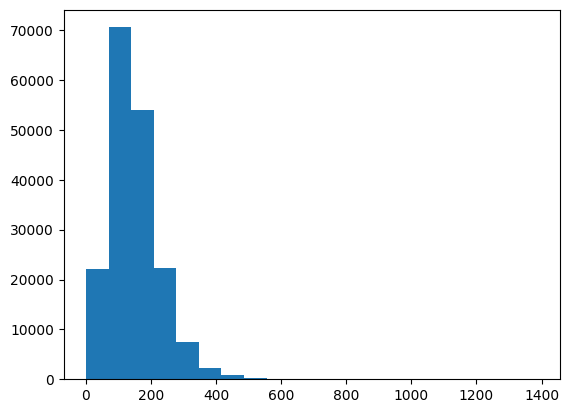

In [ ]:
# distribution
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=20);
# plt.title("Distribution of character lengths")
# plt.show

In [ ]:
# Find what character length covers 95% of sequences
output_seq_char_len = int(np.percentile(char_lens, 95))
output_seq_char_len

290

In [ ]:
# Get all keyboard characters for char-level embedding
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [ ]:
# Create char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # num characters in alphabet + space + OOV token
char_vectorizer = TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    output_sequence_length=output_seq_char_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer",
                                    output_mode="int")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
# check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(f"Number of characters in vocab: {len(char_vocab)}")
print(f"Top 5 characters: {char_vocab[:5]}")
print(f"Bottom 5 characters: {char_vocab[-5:]}")

Number of characters in vocab: 28
Top 5 characters: ['', '[UNK]', np.str_('e'), np.str_('t'), np.str_('i')]
Bottom 5 characters: [np.str_('k'), np.str_('x'), np.str_('z'), np.str_('q'), np.str_('j')]


In [ ]:
# Test out character vectorizer
random_train_chars = random.choice(train_chars)
print(f"Charified text:\n{random_train_chars}")
print(f"\nLength of chars: {len(random_train_chars.split())}")
vectorized_chars = char_vectorizer([random_train_chars])
print(f"\nVectorized chars:\n{vectorized_chars}")
print(f"\nLength of vectorized chars: {len(vectorized_chars[0])}")

Charified text:
N I G R A A N   i s   r e g i s t e r e d   w i t h   t h e   `   A u s t r a l i a n   N e w   Z e a l a n d   C l i n i c a l   T r i a l s   R e g i s t r y   '   .

Length of chars: 71

Vectorized chars:
[[ 6  4 18  8  5  5  6  4  9  8  2 18  4  9  3  2  8  2 10 20  4  3 13  3
  13  2  5 16  9  3  8  5 12  4  5  6  6  2 20 25  2  5 12  5  6 10 11 12
   4  6  4 11  5 12  3  8  4  5 12  9  8  2 18  4  9  3  8 19  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  

## Creating character level embedding

In [ ]:
# Create char embedding layer
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")

# Test out character embedding layer
print(f"Charified text (before vectorization and embedding):\n{random_train_chars}\n")
char_embed_example = char_embed(char_vectorizer([random_train_chars]))
print(f"Embedded chars (after vectorization and embedding):\n{char_embed_example}\n")
print(f"Character embedding shape: {char_embed_example.shape}")

Charified text (before vectorization and embedding):
N I G R A A N   i s   r e g i s t e r e d   w i t h   t h e   `   A u s t r a l i a n   N e w   Z e a l a n d   C l i n i c a l   T r i a l s   R e g i s t r y   '   .

Embedded chars (after vectorization and embedding):
[[[ 0.01663928 -0.00742542 -0.00019091 ... -0.01886066  0.03186886
   -0.03250764]
  [ 0.00995966  0.04762579  0.02088548 ...  0.00186279  0.01653819
   -0.02802054]
  [-0.00632297  0.03114367 -0.03590633 ...  0.01837175  0.00656891
   -0.03559832]
  ...
  [ 0.00698792 -0.01364154 -0.0193015  ...  0.0288638  -0.03866886
    0.03235975]
  [ 0.00698792 -0.01364154 -0.0193015  ...  0.0288638  -0.03866886
    0.03235975]
  [ 0.00698792 -0.01364154 -0.0193015  ...  0.0288638  -0.03866886
    0.03235975]]]

Character embedding shape: (1, 290, 25)


## building conv1d model to fit character embedding

In [ ]:
inputs = layers.Input(shape=(1,), dtype="string")
inputs.shape
output_seq_char_len

290

In [ ]:
# Make Conv1D on chars only
import tensorflow as tf
from tensorflow.keras import layers
# inputs = layers.Input(shape=(1,), dtype="string")
inputs = layers.Input(shape=(1,), dtype=tf.string)
# char_vectors = char_vectorizer(inputs) # Use the char_vectorizer directly after the input
# x = layers.Lambda(lambda x: char_vectorizer(x))(inputs)
char_vectors = char_vectorizer(inputs)
# x = char_embed(x)
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")
x = char_embed(char_vectors)
# char_embeddings = char_embed(char_vectors)
x = layers.Conv1D(filters=64, kernel_size=5, padding="same", activation="relu")(x)
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(num_classes, activation="softmax")(x)
model_3 = tf.keras.Model(inputs=inputs,
                         outputs=outputs,
                         name="model_3_conv1D_char_embedding")

# Compile model
model_3.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_3.summary()

Model: "model_3_conv1D_char_embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_vectorizer                 │ (None, 290)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ char_embed (Embedding)          │ (None, 290, 25)        │         1,750 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 290, 64)        │         8,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_1          │ (None, 64)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,139 (39.61 KB)

 Trainable params: 10,139 (39.61 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
model_3_history = model_3.fit(train_char_dataset,
            steps_per_epoch=int(0.1 * len(train_char_dataset)),
            epochs=3,
            validation_data=valid_char_dataset,
            validation_steps=int(0.1 * len(valid_char_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 17s 27ms/step - accuracy: 0.3987 - loss: 1.4097 - val_accuracy: 0.5914 - val_loss: 1.0385
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 36ms/step - accuracy: 0.5899 - loss: 1.0210 - val_accuracy: 0.6356 - val_loss: 0.9282
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 14s 25ms/step - accuracy: 0.6295 - loss: 0.9286 - val_accuracy: 0.6722 - val_loss: 0.8591


In [ ]:
model_3.evaluate(valid_char_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - accuracy: 0.6602 - loss: 0.8740


[0.875952959060669, 0.6598702669143677]

In [ ]:
model_3_pred_probs = model_3.predict(valid_char_dataset)
model_3_pred_probs[:10]

945/945 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step


array([[1.22766711e-01, 4.25939649e-01, 1.35688812e-01, 1.95287958e-01,
        1.20316707e-01],
       [2.99862027e-01, 2.60996997e-01, 4.46302118e-03, 3.78956884e-01,
        5.57210520e-02],
       [1.06074475e-01, 6.04004115e-02, 2.37060174e-01, 4.82006192e-01,
        1.14458807e-01],
       [9.27615911e-03, 3.61253992e-02, 8.42793584e-01, 1.05357133e-02,
        1.01269118e-01],
       [1.76942572e-02, 4.40646335e-02, 7.39734173e-01, 2.14228164e-02,
        1.77084118e-01],
       [3.33121367e-04, 9.24500928e-04, 7.55276740e-01, 6.17818732e-04,
        2.42847741e-01],
       [4.08233749e-03, 1.62821617e-02, 6.85741305e-01, 3.49824410e-03,
        2.90395826e-01],
       [3.04835051e-01, 2.63673812e-01, 6.61862567e-02, 2.54298538e-01,
        1.11006387e-01],
       [3.56035098e-03, 1.72291100e-02, 1.22651033e-01, 6.69978559e-03,
        8.49859655e-01],
       [1.16858333e-01, 2.93957084e-01, 1.29512653e-01, 2.84583390e-01,
        1.75088495e-01]], dtype=float32)

In [ ]:
# convert pred probs to classes
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)
model_3_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 3, 3, ..., 4, 4, 0])>

In [ ]:
model_3_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 65.9870250231696,
 'precision': 0.6536818819256682,
 'recall': 0.659870250231696,
 'f1': 0.6505672176586368}

## Model 4: Combining pretrained token embeddings + characters embeddings (hybrid embedding layer)

1. create token level embedding
2. create character level model
3. combine 1 and 2 with a concatenate layer
4. build series of output layers

In [ ]:
# Enable XLA
tf.config.optimizer.set_jit(True)  # Enable XLA (just-in-time compilation)


# Assume you have a pre-trained embedding layer URL
tf_hub_embedding_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

# Define the custom layer for the Universal Sentence Encoder
class UniversalSentenceEncoderLayer(layers.Layer):
    def __init__(self, hub_layer):
        super().__init__()
        self.encoder = hub_layer

    def call(self, inputs):
        return self.encoder(inputs)

use_layer = UniversalSentenceEncoderLayer(tf_hub_embedding_layer)

# 1. Setup input model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
# token_embeddings = tf_hub_embedding_layer(token_inputs)
token_embeddings = use_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                          outputs=token_outputs,
                          name="token_model")

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=25, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(25))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                          outputs=char_bi_lstm,
                          name="char_model")
# 3. combine 1 and 2 with a concatenate layer
token_char_concat = layers.Concatenate(name="token_char_hybrid")([token_model.output, char_model.output])
# 4. build series of output layers
combined_droput = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation="relu")(combined_droput)
final_dropout = layers.Dropout(0.5)(combined_dense)
output_layer = layers.Dense(num_classes, activation="softmax")(final_dropout)
#5. construct model
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         name="model_4_hybrid_embedding")



In [ ]:
model_4.summary()

Model: "model_4_hybrid_embedding"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_input         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 290)       │          0 │ char_input[0][0]  │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ universal_sentence… │ (None, 512)       │          0 │ token_input[0][0] │
│ (UniversalSentence… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embed          │ (None, 290, 25)   │      1,750 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     65,664 │ universal_senten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 50)        │     10,200 │ char_embed[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_char_hybrid   │ (None, 178)       │          0 │ dense_2[0][0],    │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 178)       │          0 │ token_char_hybri… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     22,912 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 5)         │        645 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 101,171 (395.20 KB)

 Trainable params: 101,171 (395.20 KB)

 Non-trainable params: 0 (0.00 B)

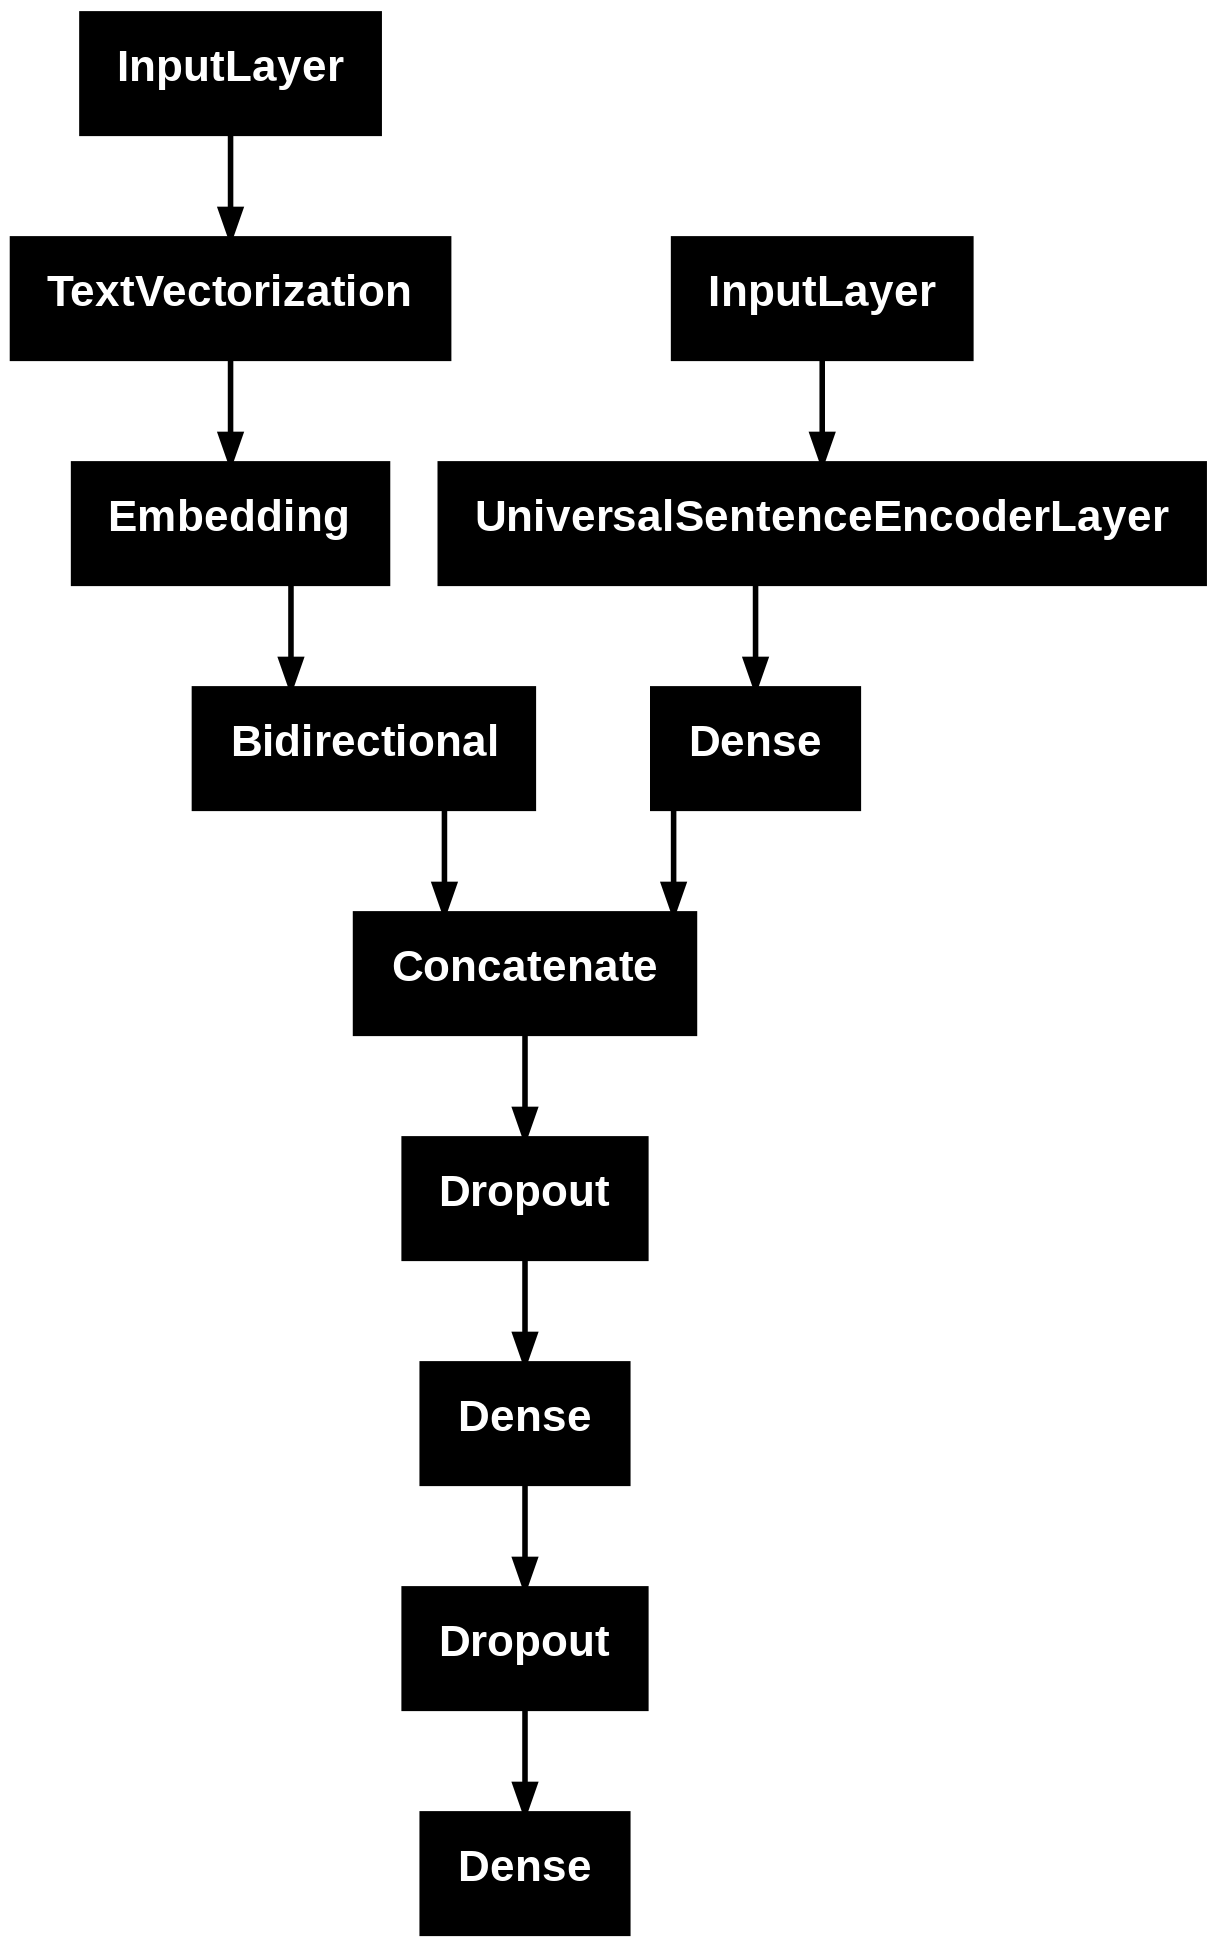

In [ ]:
from keras.utils import plot_model
plot_model(model_4)

In [ ]:
# Compile
model_4.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels))

train_char_token_dataset = train_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_char_token_data = tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels))

val_char_token_dataset = val_char_token_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_dataset, val_char_token_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
history_model_4 = model_4.fit(train_char_token_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
                              epochs=3,
                              validation_data=val_char_token_dataset,
                              validation_steps=int(0.1 * len(val_char_token_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 143s 241ms/step - accuracy: 0.5249 - loss: 1.1697 - val_accuracy: 0.6988 - val_loss: 0.7905
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 132s 234ms/step - accuracy: 0.6896 - loss: 0.8105 - val_accuracy: 0.7284 - val_loss: 0.7202
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 130s 232ms/step - accuracy: 0.7019 - loss: 0.7766 - val_accuracy: 0.7327 - val_loss: 0.6961


In [ ]:
model_1_results

{'accuracy': 80.42830663312591,
 'precision': 0.8029838732521131,
 'recall': 0.8042830663312591,
 'f1': 0.802570801682686}

In [ ]:
model_4.evaluate(val_char_token_dataset)

945/945 ━━━━━━━━━━━━━━━━━━━━ 55s 59ms/step - accuracy: 0.7297 - loss: 0.7007


[0.7022393345832825, 0.7292797565460205]

In [ ]:
model_4_pred_probs = model_4.predict(val_char_token_dataset)
model_4_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 54s 57ms/step


array([[3.3624822e-01, 4.6332768e-01, 3.9132363e-03, 1.8833342e-01,
        8.1773577e-03],
       [3.3826789e-01, 4.9120626e-01, 2.1487654e-03, 1.6695555e-01,
        1.4214859e-03],
       [3.4936807e-01, 1.8223195e-01, 5.5921126e-02, 3.7514231e-01,
        3.7336521e-02],
       ...,
       [7.4595620e-04, 1.0549668e-02, 6.2526017e-02, 2.6074855e-04,
        9.2591763e-01],
       [6.7957602e-03, 5.5602230e-02, 2.5765267e-01, 2.8638723e-03,
        6.7708546e-01],
       [2.7676350e-01, 3.3812365e-01, 3.0022672e-01, 2.7994188e-02,
        5.6891911e-02]], dtype=float32)

In [ ]:
# format pred probs into pred labels
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([1, 1, 3, ..., 4, 4, 1])>

In [ ]:
# get results of token char hybrid
model_4_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 72.927975638819,
 'precision': 0.7310330163211356,
 'recall': 0.7292797563881901,
 'f1': 0.7263688703354045}

## Model 5: transfer learning. pretrained token embedding + character embedding + positional embedding

Create positional embedding

In [ ]:
train_df["line_number"].value_counts()

,count
line_number,
0,15000
1,15000
2,15000
3,15000
4,14992
5,14949
6,14758
7,14279
8,13346


<Axes: ylabel='Frequency'>

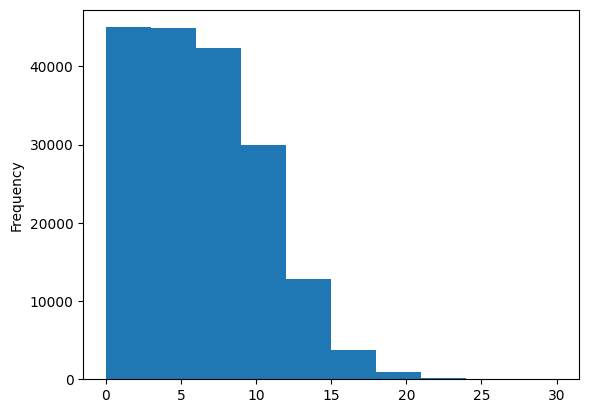

In [ ]:
train_df["line_number"].plot.hist()

In [ ]:
train_line_numbers_one_hot = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)
train_line_numbers_one_hot
val_line_numbers_one_hot
test_line_numbers_one_hot

<tf.Tensor: shape=(30135, 15), dtype=float32, numpy=
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

In [ ]:
train_df["total_lines"].value_counts()

,count
total_lines,
11,24468
10,23639
12,22113
9,19400
13,18438
14,14610
8,12285
15,10768
7,7464


<Axes: ylabel='Frequency'>

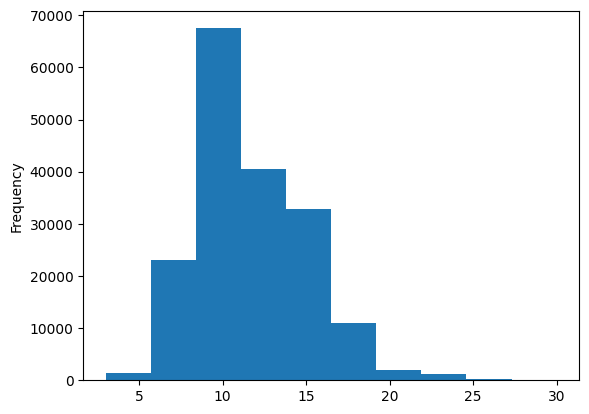

In [ ]:
train_df["total_lines"].plot.hist()

In [ ]:
np.percentile(train_df["total_lines"], 95)

np.float64(18.0)

In [ ]:
train_total_lines_one_hot = tf.one_hot(train_df["total_lines"].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df["total_lines"].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df["total_lines"].to_numpy(), depth=20)
train_total_lines_one_hot
val_total_lines_one_hot
test_total_lines_one_hot

<tf.Tensor: shape=(30135, 20), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)>

In [ ]:
train_line_numbers_one_hot[0].shape

TensorShape([15])

In [ ]:
# Enable XLA
tf.config.optimizer.set_jit(True)  # Enable XLA (just-in-time compilation)


# Assume you have a pre-trained embedding layer URL
tf_hub_embedding_layer_url = "https://tfhub.dev/google/universal-sentence-encoder/4"

# Define the custom layer for the Universal Sentence Encoder
@tf.keras.saving.register_keras_serializable()
class UniversalSentenceEncoderLayer(layers.Layer):
    def __init__(self, hub_url, **kwargs):
        super().__init__(**kwargs)
        self.hub_url = hub_url
        self.encoder = hub.KerasLayer(self.hub_url, trainable=False)

    def call(self, inputs):
        return self.encoder(inputs)

    def get_config(self):
        config = super().get_config()
        config.update({
            "hub_url": self.hub_url,
        })
        return config

    @classmethod
    def from_config(cls, config):
        hub_url = config.pop("hub_url")
        return cls(hub_url, **config)

use_layer = UniversalSentenceEncoderLayer(tf_hub_embedding_layer_url)

# 1. Setup input model
token_inputs = layers.Input(shape=[], dtype=tf.string, name="token_input")
token_embeddings = use_layer(token_inputs)
token_outputs = layers.Dense(128, activation="relu")(token_embeddings)
token_model = tf.keras.Model(inputs=token_inputs,
                          outputs=token_outputs,
                          name="token_model")

# 2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name="char_input")
char_vectors = char_vectorizer(char_inputs)
char_embed = layers.Embedding(input_dim=NUM_CHAR_TOKENS, # number of different characters
                              output_dim=24, # embedding dimension of each character (same as Figure 1 in https://arxiv.org/pdf/1612.05251.pdf)
                              mask_zero=False, # don't use masks (this messes up model_5 if set to True)
                              name="char_embed")
char_embeddings = char_embed(char_vectors)
char_bi_lstm = layers.Bidirectional(layers.LSTM(24))(char_embeddings)
char_model = tf.keras.Model(inputs=char_inputs,
                          outputs=char_bi_lstm,
                          name="char_model")

# 3. Line numbers model
line_number_inputs = layers.Input(shape=(15,), dtype=tf.float32, name="line_number_input")
x = layers.Dense(128, activation="relu")(line_number_inputs)
line_number_model = tf.keras.Model(inputs=line_number_inputs,
                                  outputs=x)

# 4. Line total model
line_total_inputs = layers.Input(shape=(20,), dtype=tf.float32, name="line_total_input") # Changed shape from 15 to 20
y = layers.Dense(128, activation="relu")(line_total_inputs)
line_total_model = tf.keras.Model(inputs=line_total_inputs,
                                  outputs=y)

In [ ]:
# 5. combine models
combined_embeddings = layers.Concatenate(name="token_char_hybrid_embedding")([token_model.output, char_model.output])

z = layers.Dense(256, activation="relu")(combined_embeddings)
z = layers.Dropout(0.5)(z)

# 6. combine models
tribrid_embeddings = layers.Concatenate(name="tribrid_embeddings")([line_number_model.output, line_total_model.output, z])

In [ ]:
# 7. output layer
output_layer = layers.Dense(num_classes, activation="softmax", name="output_layer")(tribrid_embeddings)
# 8. create model
model_5 = tf.keras.Model(inputs=[line_number_model.input,
                                 line_total_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer,
                         name="tribrid_embeddings_model")

In [ ]:
model_5.summary()

Model: "tribrid_embeddings_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_input         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 290)       │          0 │ char_input[0][0]  │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ universal_sentence… │ (None, 512)       │          0 │ token_input[0][0] │
│ (UniversalSentence… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embed          │ (None, 290, 24)   │      1,680 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     65,664 │ universal_senten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 48)        │      9,408 │ char_embed[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_char_hybrid_… │ (None, 176)       │          0 │ dense_5[0][0],    │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ line_number_input   │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ line_total_input    │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │     45,312 │ token_char_hybri… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │      2,048 │ line_number_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │      2,688 │ line_total_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tribrid_embeddings  │ (None, 512)       │          0 │ dense_6[0][0],    │
│ (Concatenate)       │                   │            │ dense_7[0][0],    │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 5)         │      2,565 │ tribrid_embeddin… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 129,365 (505.33 KB)

 Trainable params: 129,365 (505.33 KB)

 Non-trainable params: 0 (0.00 B)

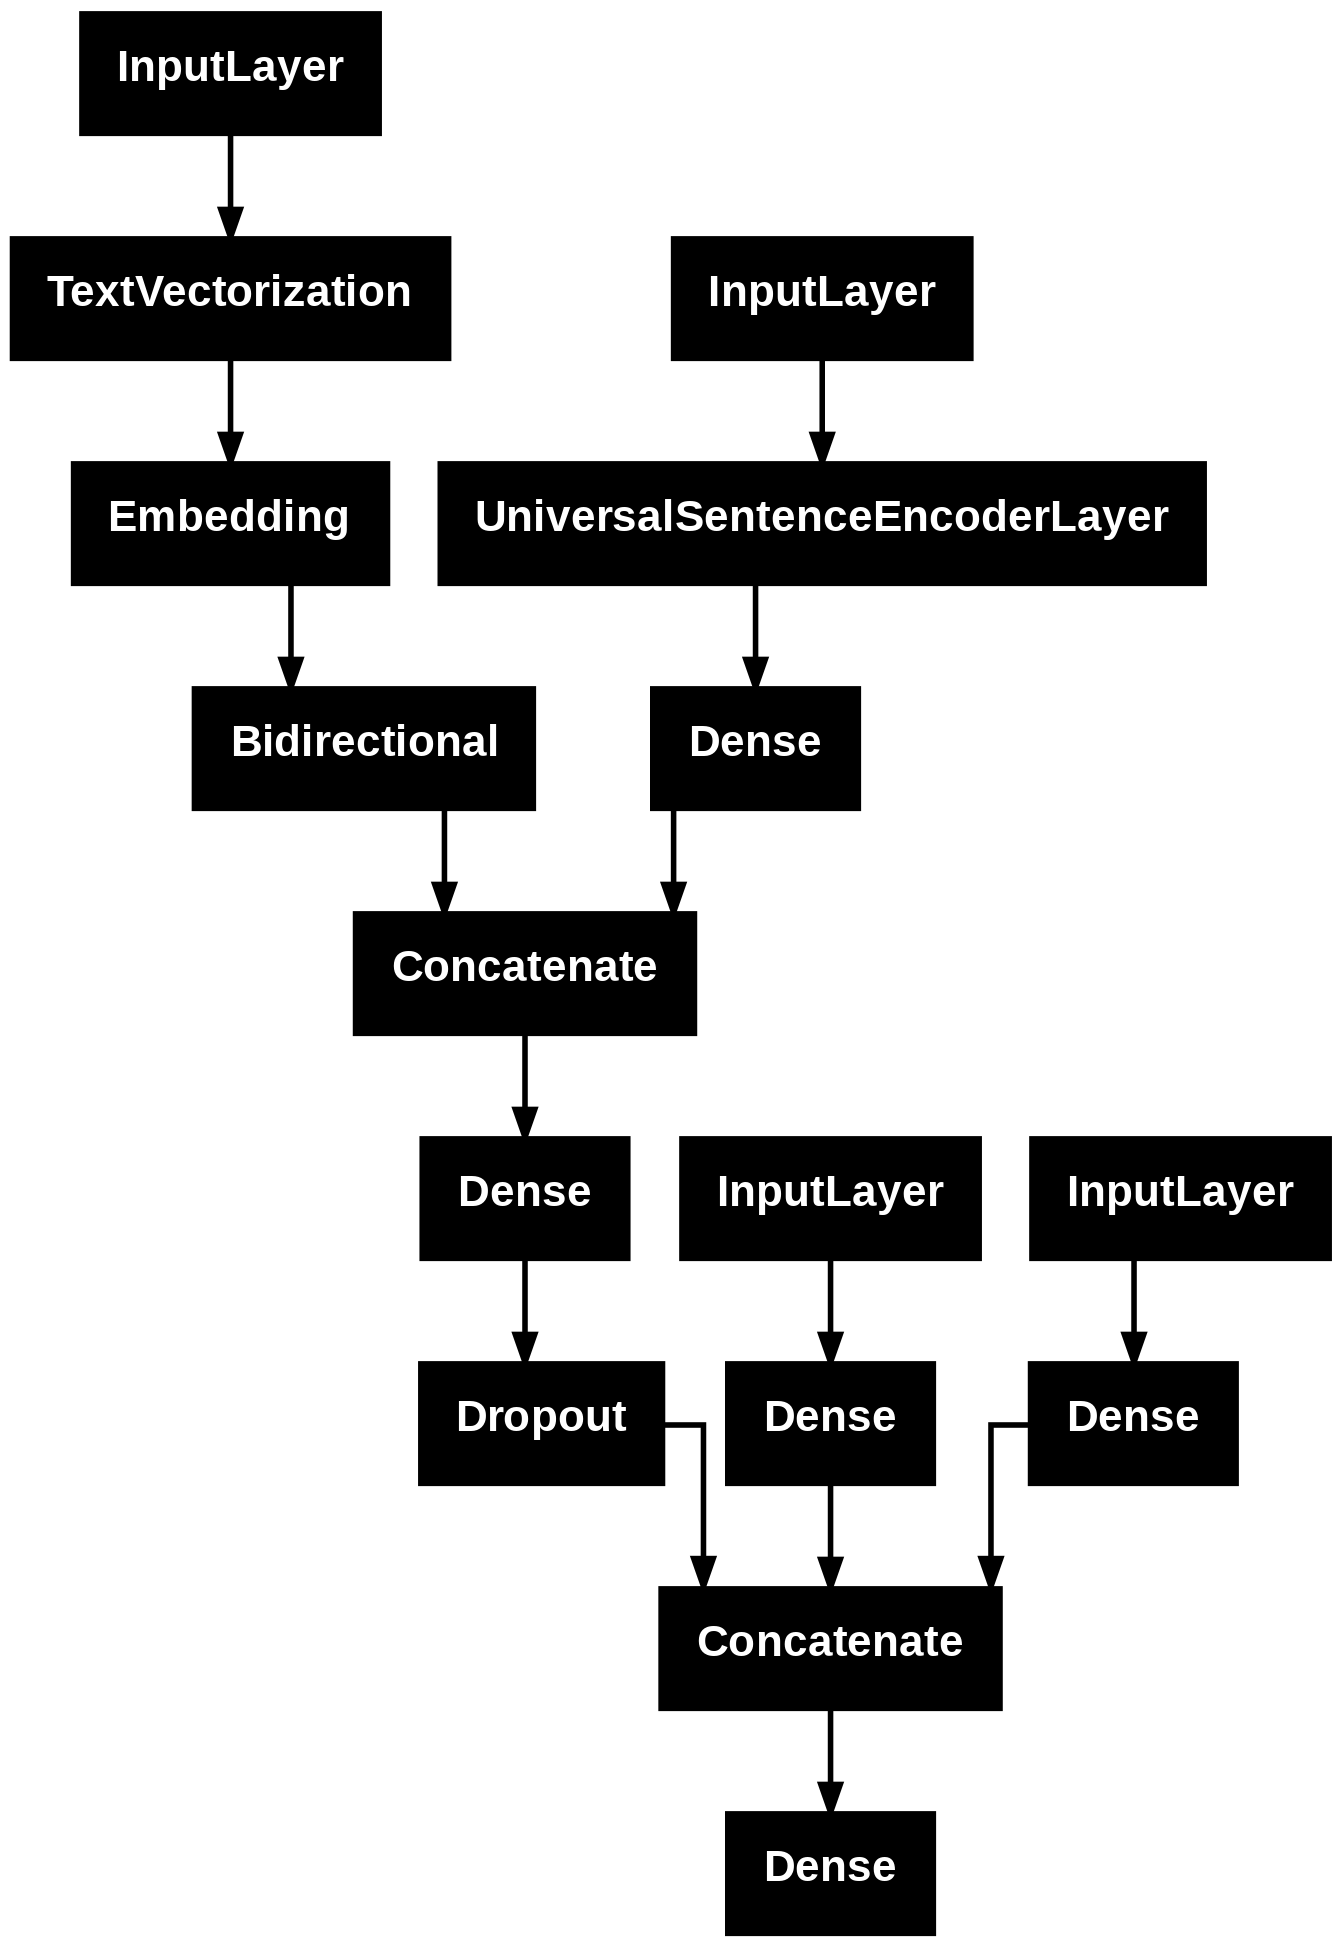

In [ ]:
plot_model(model_5)

In [ ]:
# Compile
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
train_char_token_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_one_hot,
                                                                train_total_lines_one_hot,
                                                                train_sentences,
                                                                train_chars))
train_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_pos_dataset = tf.data.Dataset.zip((train_char_token_pos_data, train_char_token_pos_labels))
train_char_token_pos_dataset = train_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_char_token_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_one_hot,
                                                                val_total_lines_one_hot,
                                                                val_sentences,
                                                                val_chars))
val_char_token_pos_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_pos_dataset = tf.data.Dataset.zip((val_char_token_pos_data, val_char_token_pos_labels))
val_char_token_pos_dataset = val_char_token_pos_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_char_token_pos_dataset, val_char_token_pos_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [ ]:
history_model_5 = model_5.fit(train_char_token_pos_dataset,
                              steps_per_epoch=int(0.1 * len(train_char_token_pos_dataset)),
                              epochs=3,
                              validation_data=val_char_token_pos_dataset,
                              validation_steps=int(0.1 * len(val_char_token_pos_dataset)))

Epoch 1/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 136s 226ms/step - accuracy: 0.6454 - loss: 1.1898 - val_accuracy: 0.8075 - val_loss: 0.9736
Epoch 2/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 133s 236ms/step - accuracy: 0.8148 - loss: 0.9669 - val_accuracy: 0.8308 - val_loss: 0.9491
Epoch 3/3
562/562 ━━━━━━━━━━━━━━━━━━━━ 124s 221ms/step - accuracy: 0.8234 - loss: 0.9508 - val_accuracy: 0.8338 - val_loss: 0.9389


In [ ]:
model_5_pred_probs = model_5.predict(val_char_token_pos_dataset, verbose=1)
model_5_pred_probs

945/945 ━━━━━━━━━━━━━━━━━━━━ 51s 53ms/step


array([[0.50385946, 0.09022697, 0.00760221, 0.38287902, 0.01543233],
       [0.5911967 , 0.08815269, 0.03094842, 0.28149825, 0.00820392],
       [0.26715797, 0.11061647, 0.13278699, 0.42254826, 0.06689023],
       ...,
       [0.0311561 , 0.0925649 , 0.03995818, 0.02992267, 0.8063981 ],
       [0.03596359, 0.36032724, 0.07267794, 0.02972452, 0.50130665],
       [0.21854264, 0.57069874, 0.09372264, 0.04972673, 0.06730919]],
      dtype=float32)

In [ ]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)
model_5_preds


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 0, 3, ..., 4, 4, 1])>

In [ ]:
model_5_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 83.58268237786311,
 'precision': 0.834668803840655,
 'recall': 0.835826823778631,
 'f1': 0.8348927847906333}

# compare model results

In [ ]:
all_model_results = pd.DataFrame({"model_0_baseline": baseline_results,
                                 "model_1": model_1_results,
                                  "model_2": model_2_results,
                                  "model_3": model_3_results,
                                  "model_4": model_4_results,
                                  "model_5": model_5_results})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.718647,0.721832,0.698925
model_1,80.428307,0.802984,0.804283,0.802571
model_2,71.266384,0.713140,0.712664,0.709762
model_3,65.987025,0.653682,0.659870,0.650567
model_4,72.927976,0.731033,0.729280,0.726369
model_5,83.582682,0.834669,0.835827,0.834893


In [ ]:
all_model_results["accuracy"] = all_model_results["accuracy"]/100

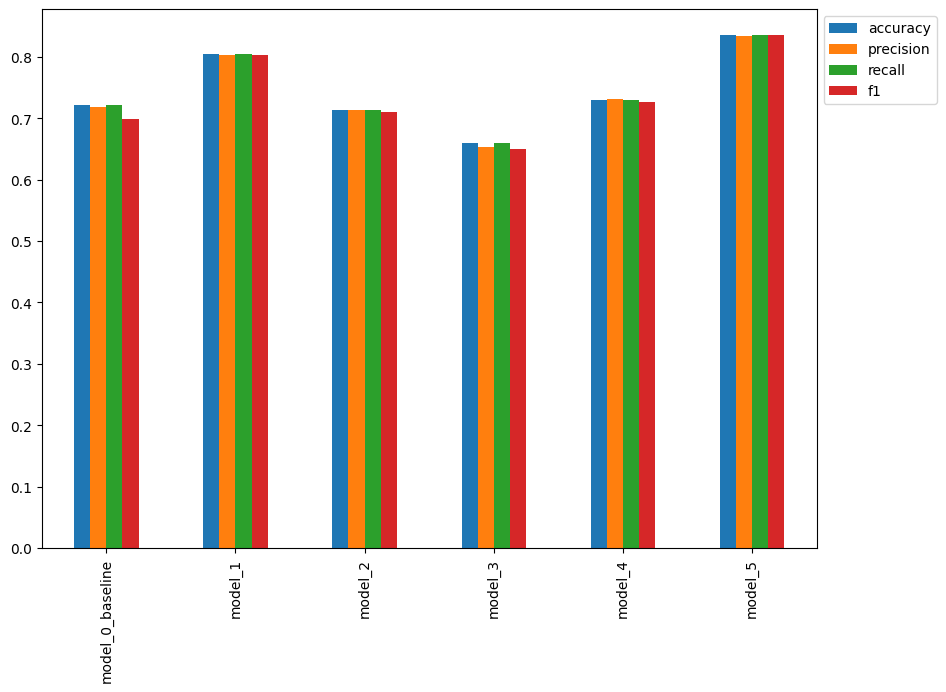

In [ ]:
all_model_results.plot(kind="bar", figsize=(10,7)).legend(bbox_to_anchor=(1.0, 1.0))

<Axes: >

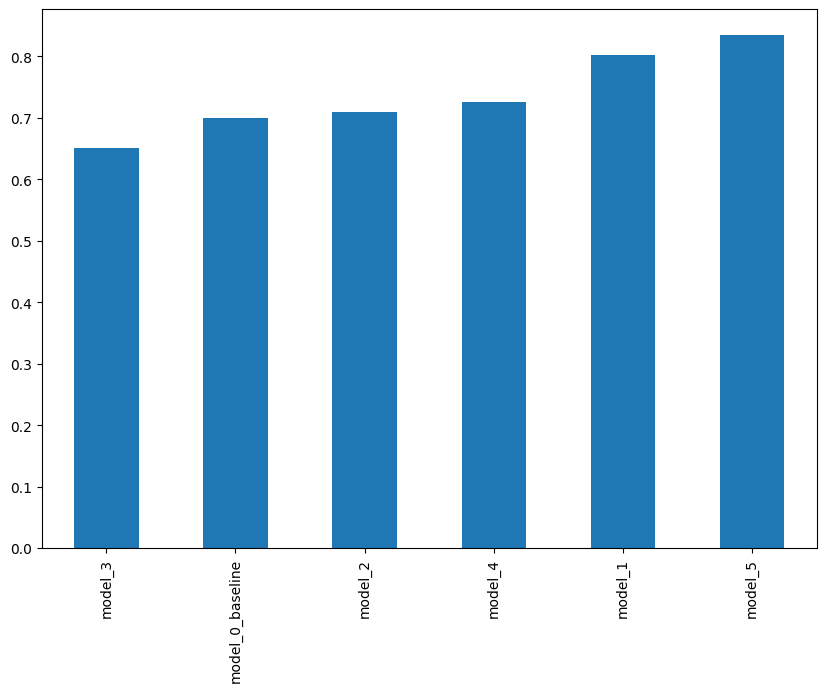

In [ ]:
all_model_results.sort_values("f1", ascending=True)["f1"].plot(kind="bar", figsize=(10,7))

# save and load

In [ ]:
model_5.save("model_5.keras")

In [ ]:
loaded_model_5 = tf.keras.models.load_model("model_5.keras")

In [ ]:
loaded_pred_probs = loaded_model_5.predict(val_char_token_pos_dataset)
loaded_pred = tf.argmax(loaded_pred_probs, axis=1)
loaded_pred[:10]

945/945 ━━━━━━━━━━━━━━━━━━━━ 85s 87ms/step


<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 3, 2, 2, 4, 4, 4, 4, 1])>

In [ ]:
loaded_results = calculate_results(y_true=val_labels_encoded,
                                    y_pred=loaded_pred)
loaded_results

{'accuracy': 83.58268237786311,
 'precision': 0.834668803840655,
 'recall': 0.835826823778631,
 'f1': 0.8348927847906333}

In [ ]:
loaded_model_5.summary()

Model: "tribrid_embeddings_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ char_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_input         │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_vectorizer     │ (None, 290)       │          0 │ char_input[0][0]  │
│ (TextVectorization) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ universal_sentence… │ (None, 512)       │          0 │ token_input[0][0] │
│ (UniversalSentence… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ char_embed          │ (None, 290, 24)   │      1,680 │ char_vectorizer[… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     65,664 │ universal_senten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 48)        │      9,408 │ char_embed[0][0]  │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_char_hybrid_… │ (None, 176)       │          0 │ dense_5[0][0],    │
│ (Concatenate)       │                   │            │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ line_number_input   │ (None, 15)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ line_total_input    │ (None, 20)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 256)       │     45,312 │ token_char_hybri… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │      2,048 │ line_number_inpu… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │      2,688 │ line_total_input… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 256)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tribrid_embeddings  │ (None, 512)       │          0 │ dense_6[0][0],    │
│ (Concatenate)       │                   │            │ dense_7[0][0],    │
│                     │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 5)         │      2,565 │ tribrid_embeddin… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 388,097 (1.48 MB)

 Trainable params: 129,365 (505.33 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 258,732 (1010.68 KB)